# What's different?

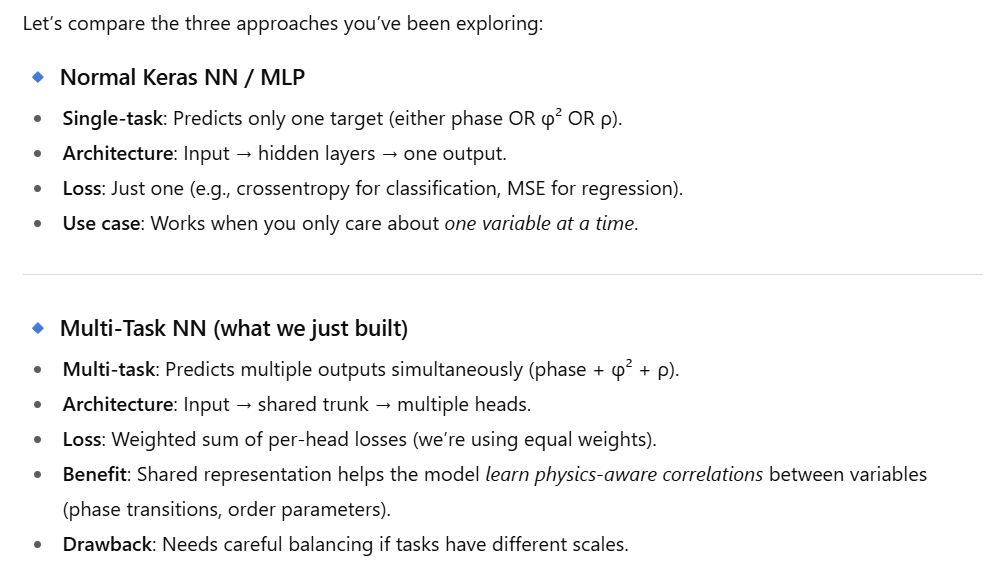

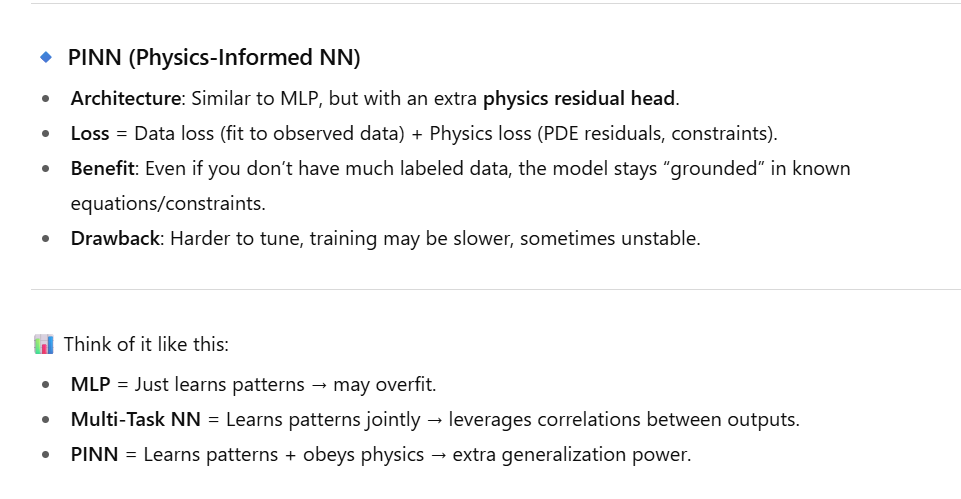

# Results Summary

## Full dataset
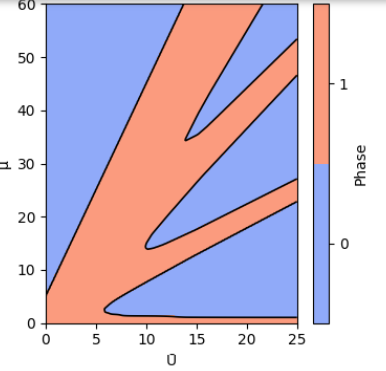

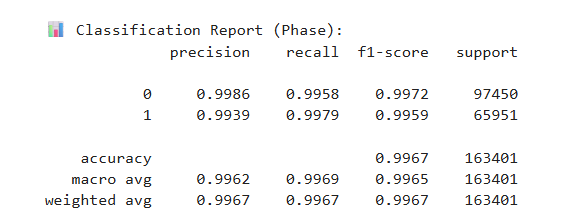
## 4k dataset
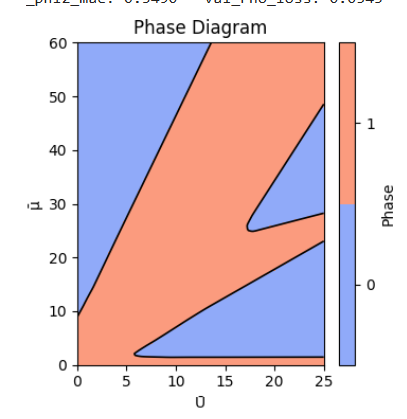

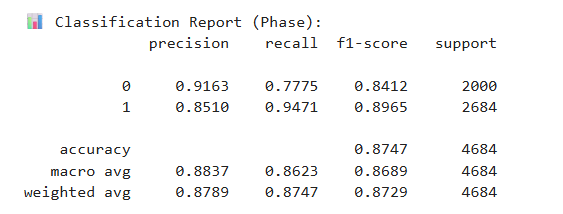

## 6k Dataset
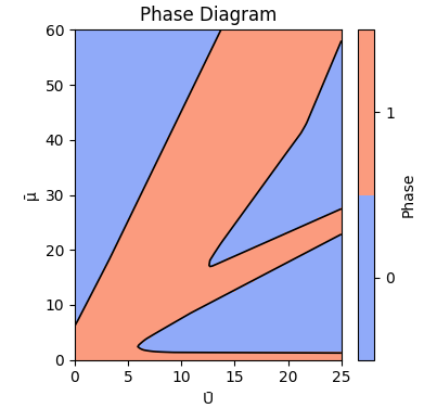
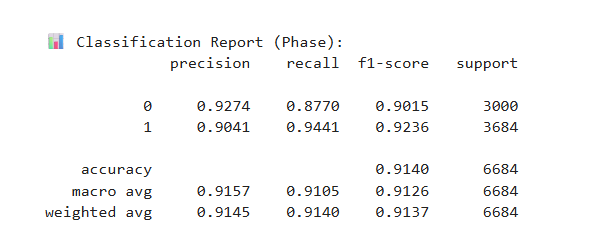
## 10k dataset
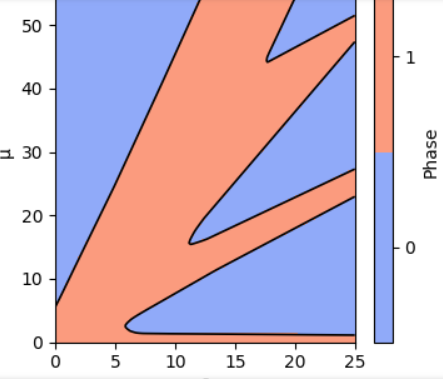
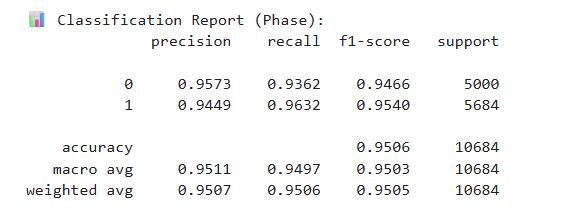

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

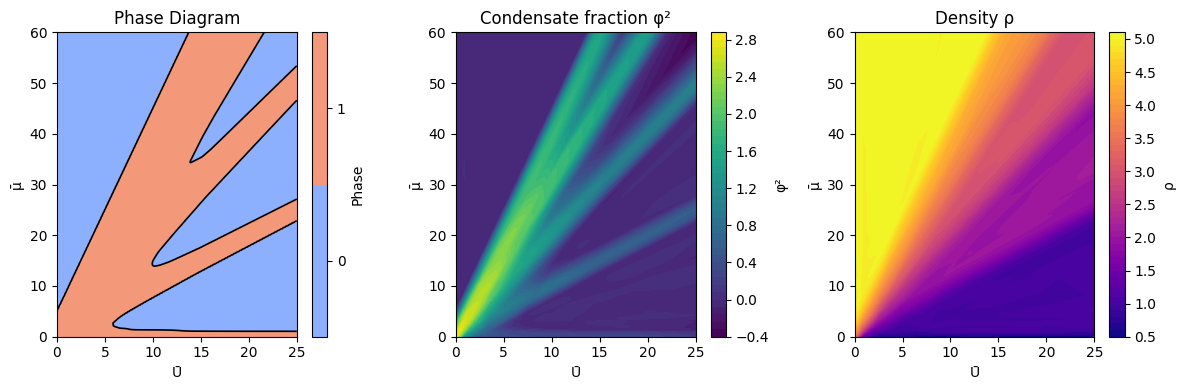

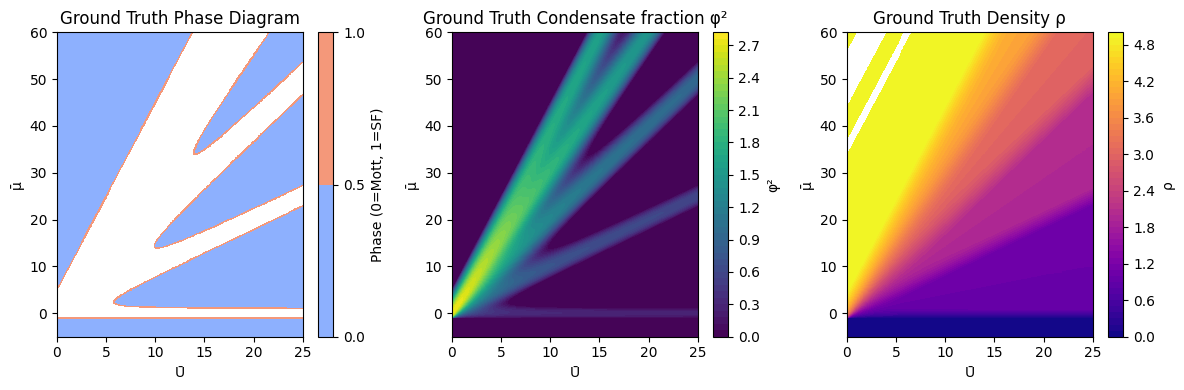


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9986    0.9958    0.9972     97450
           1     0.9939    0.9979    0.9959     65951

    accuracy                         0.9967    163401
   macro avg     0.9962    0.9969    0.9965    163401
weighted avg     0.9967    0.9967    0.9967    163401



C:\Users\DELL\AppData\Local\Temp\ipykernel_23660\825025126.py:186: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
# --- 1) Load data ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)
print(df)

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


# Reduced Dataset

## 6.6k Dataset

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

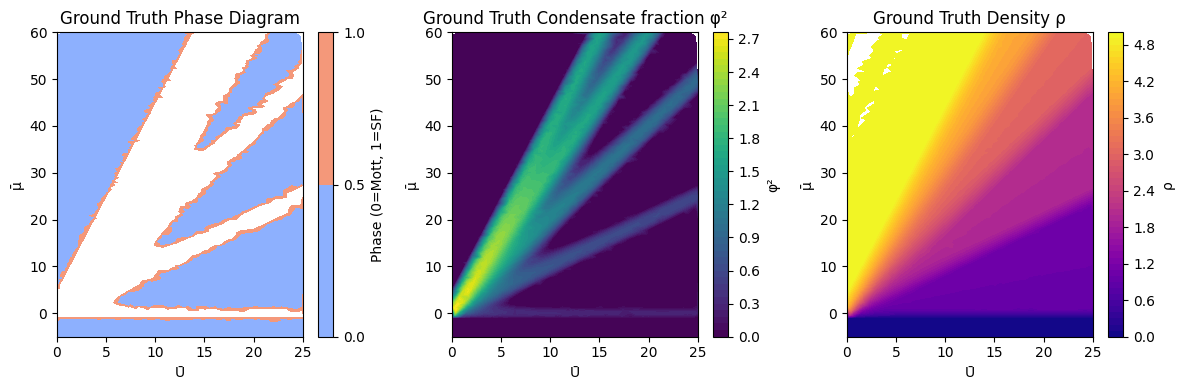

NameError: name 'layers' is not defined

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(3000, len(df_MI))
n_SF = min(3000, len(df_SF))
n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title(f"Phase Diagram for Multi-task NN",fontsize=12, fontweight="bold")
plt.savefig('6k-multi-nn', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



##  6k extra

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(3000, len(df_MI))
n_SF = min(3000, len(df_SF))
n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 40, 200)
mu_vals = np.linspace(0, 70, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title(f"Phase Diagram for Multi-task NN",fontsize=12, fontweight="bold")
plt.savefig('6k-extra-multi-nn', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))



##  4k dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVCimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(2000, len(df_MI))
n_SF = min(2000, len(df_SF))
n_boundary = min(4000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title(f"Phase Diagram for Multi-task NN",fontsize=12, fontweight="bold")
plt.savefig('4k-multi-nn', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import kerasimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(2000, len(df_MI))
n_SF = min(2000, len(df_SF))
n_boundary = min(4000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title(f"Phase Diagram for Multi-task NN",fontsize=12, fontweight="bold")
plt.savefig('4k-multi-nn', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
#Smart sampling strategy
#------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

# # n_MI = min(5000, len(df_MI))
# # n_SF = min(5000, len(df_SF))
# # n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 3.2086 - phase_accuracy: 0.4619 - phase_loss: 0.7907 - phi2_loss: 3.3060 - phi2_mae: 1.3476 - rho_loss: 1.4513 - rho_mae: 0.9008 - val_loss: 2.0992 - val_phase_accuracy: 0.0000e+00 - val_phase_loss: 0.9340 - val_phi2_loss: 0.9910 - val_phi2_mae: 0.8835 - val_rho_loss: 1.3347 - val_rho_mae: 0.7693 - learning_rate: 0.0010
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7239 - phase_accuracy: 0.6001 - phase_loss: 0.6693 - phi2_loss: 0.8245 - phi2_mae: 0.7224 - rho_loss: 1.2790 - rho_mae: 0.8228 - val_loss: 1.6179 - val_phase_accuracy: 0.2191 - val_phase_loss: 0.8756 - val_phi2_loss: 0.1658 - val_phi2_mae: 0.3086 - val_rho_loss: 1.3079 - val_rho_mae: 0.6946 - learning_rate: 0.0010
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5014 - phase_accuracy: 0.7023 - phase_loss: 0.6307 - phi2_loss: 0.5434 - phi2_mae: 0.5568 - rho_loss: 1.1933 - rho_mae: 0.7780 - val_loss: 1.6673 - val_phase_accuracy: 0.2162 - val

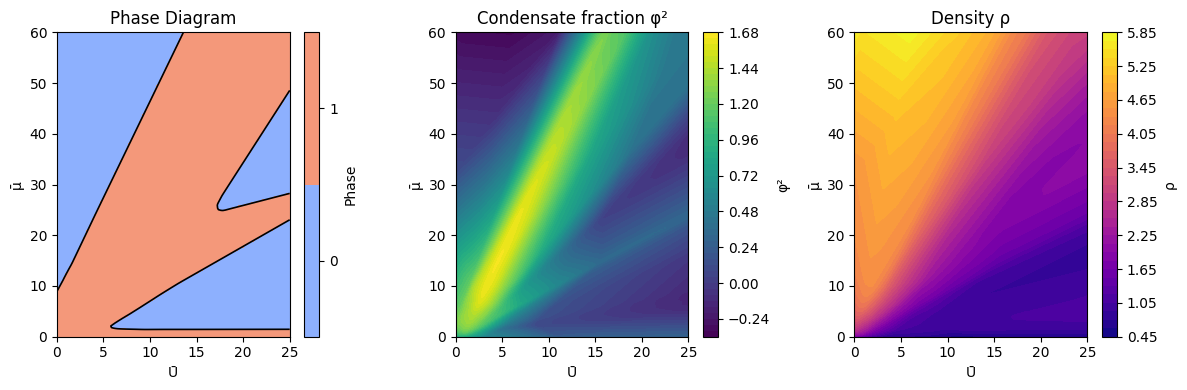

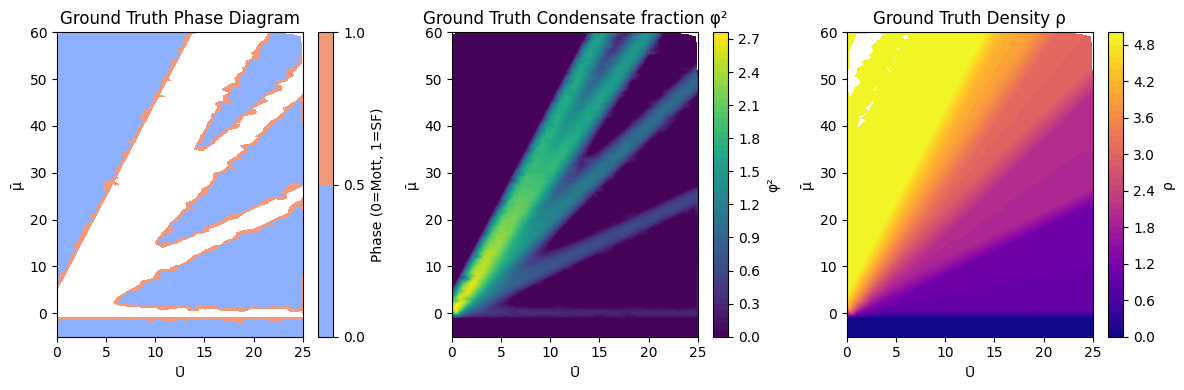


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9163    0.7775    0.8412      2000
           1     0.8510    0.9471    0.8965      2684

    accuracy                         0.8747      4684
   macro avg     0.8837    0.8623    0.8689      4684
weighted avg     0.8789    0.8747    0.8729      4684



C:\Users\DELL\AppData\Local\Temp\ipykernel_23660\1202470403.py:138: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [14]:
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


## 4k extra

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVCimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(2000, len(df_MI))
n_SF = min(2000, len(df_SF))
n_boundary = min(4000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title(f"Phase Diagram for Multi-task NN",fontsize=12, fontweight="bold")
plt.savefig('4k-multi-nn', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import kerasimport numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
# Smart sampling strategy
# ------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

# n_MI = min(5000, len(df_MI))
# n_SF = min(5000, len(df_SF))
# n_boundary = min(10000, len(df_boundary))

n_MI = min(2000, len(df_MI))
n_SF = min(2000, len(df_SF))
n_boundary = min(4000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()

# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 40, 200)
mu_vals = np.linspace(0, 70, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("U",fontsize=10,fontweight="bold")
plt.ylabel("μ̄",fontsize=10, fontweight="bold")
plt.title(f"Phase Diagram for Multi-task NN",fontsize=12, fontweight="bold")
plt.savefig('4k-extra-multi-nn', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
#Smart sampling strategy
#------------------------------
n_MI = min(2000, len(df_MI))             # cap deep MI
n_SF = min(2000, len(df_SF))             # cap deep SF
n_boundary = min(6000, len(df_boundary)) # oversample boundary

# # n_MI = min(5000, len(df_MI))
# # n_SF = min(5000, len(df_SF))
# # n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (3448408477.py, line 9)

## 10k dataset 

          t  Ubar  Mubar       Density          Phi2        Energy  Iters  \
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8   
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8   
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8   
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8   
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8   
...     ...   ...    ...           ...           ...           ...    ...   
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21   
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21   
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21   
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21   
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21   

        Phase  
0           0  
1           0  
2           0  
3          

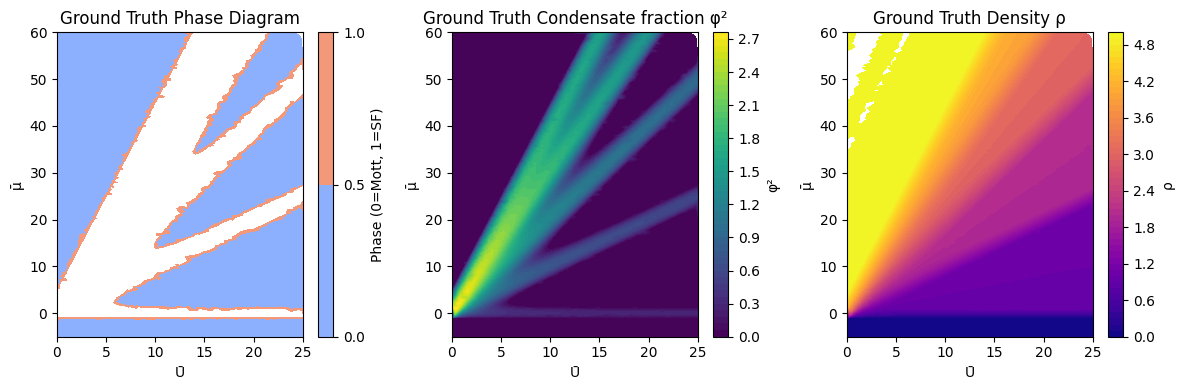

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# # ---------- 1) Load and label ----------
# df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# # Apply physics-based labeling
# df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Apply physics-based labeling (optional, but consistent)
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)




# --- pick deep MI (phi2 ≈ 0, density ~ integer) ---



df_MI = df[
    (df["Phi2"] < 1e-8) &
    (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3))
]

# --- pick deep SF (large phi2) ---
df_SF = df[df["Phi2"] > 1e-2]

# --- pick boundary (ambiguous region) ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)
]

# ------------------------------
#Smart sampling strategy
#------------------------------
# n_MI = min(2000, len(df_MI))             # cap deep MI
# n_SF = min(2000, len(df_SF))             # cap deep SF
# n_boundary = min(6000, len(df_boundary)) # oversample boundary

n_MI = min(5000, len(df_MI))
n_SF = min(5000, len(df_SF))
n_boundary = min(10000, len(df_boundary))

# n_MI = min(3000, len(df_MI))
# n_SF = min(3000, len(df_SF))
# n_boundary = min(6000, len(df_boundary))


df_reduced = pd.concat([
    df_MI.sample(n_MI, random_state=42),
    df_SF.sample(n_SF, random_state=42),
    df_boundary.sample(n_boundary, random_state=42)
])
print(df)
df_reduced = df_reduced.reset_index(drop=True)
# Use reduced dataset
df = df_reduced.reset_index(drop=True)
print(df)


print("Reduced dataset summary:")
print(df_reduced["Phase"].value_counts())

# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 6.0857 - phase_accuracy: 0.5919 - phase_loss: 0.8525 - phi2_loss: 3.9972 - phi2_mae: 1.4909 - rho_loss: 6.3315 - rho_mae: 1.6953 - val_loss: 1.7607 - val_phase_accuracy: 0.6781 - val_phase_loss: 0.8195 - val_phi2_loss: 0.5089 - val_phi2_mae: 0.5471 - val_rho_loss: 1.4014 - val_rho_mae: 0.8392 - learning_rate: 0.0010
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4211 - phase_accuracy: 0.7143 - phase_loss: 0.5636 - phi2_loss: 0.4977 - phi2_mae: 0.5020 - rho_loss: 1.2137 - rho_mae: 0.7877 - val_loss: 1.7536 - val_phase_accuracy: 0.4629 - val_phase_loss: 0.9234 - val_phi2_loss: 0.4231 - val_phi2_mae: 0.4631 - val_rho_loss: 1.2519 - val_rho_mae: 0.7835 - learning_rate: 0.0010
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2795 - phase_accuracy: 0.7445 - phase_loss: 0.5263 - phi2_loss: 0.4231 - phi2_mae: 0.4308 - rho_loss: 1.0877 - rho_mae: 0.7275 - val_loss: 1.6711 - val_phase_accuracy: 0.4523 - val_pha

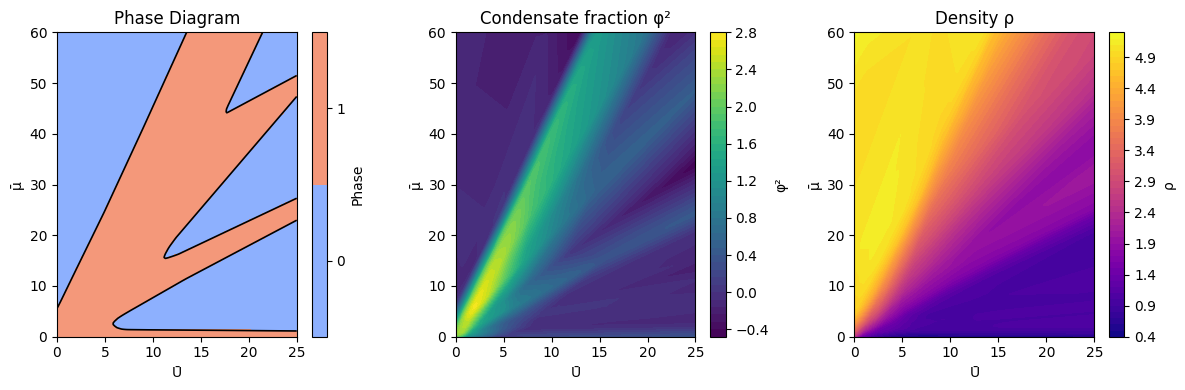

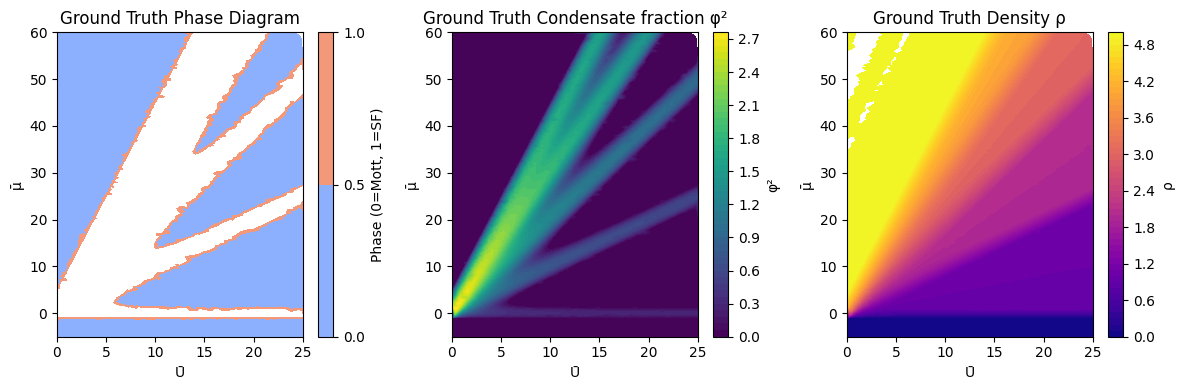


📊 Classification Report (Phase):
              precision    recall  f1-score   support

           0     0.9573    0.9362    0.9466      5000
           1     0.9449    0.9632    0.9540      5684

    accuracy                         0.9506     10684
   macro avg     0.9511    0.9497    0.9503     10684
weighted avg     0.9507    0.9506    0.9505     10684



C:\Users\DELL\AppData\Local\Temp\ipykernel_23660\1202470403.py:138: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_true_labels = df["Phase"].astype(int).ravel()


In [16]:
# Features and targets
X = df[["Ubar","Mubar"]].values.astype(np.float32)
y = {
    "phase": df["Phase"].values.astype(np.float32),
    "phi2": df["Phi2"].values.astype(np.float32),
    "rho": df["Density"].values.astype(np.float32),
}

# --- 2) Build Multi-task NN ---
def make_multitask_nn(hidden=(128,64)):
    inp = keras.Input(shape=(2,), name="input")   # (Ū, μ̄)

    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)

    # Three heads
    phase_out = layers.Dense(1, activation="sigmoid", name="phase")(x)
    phi_out   = layers.Dense(1, activation="linear", name="phi2")(x)
    rho_out   = layers.Dense(1, activation="linear", name="rho")(x)

    model = keras.Model(inputs=inp, outputs=[phase_out, phi_out, rho_out])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss={
            "phase": "binary_crossentropy",
            "phi2": "mse",
            "rho": "mse"
        },
        loss_weights={"phase": 1.0, "phi2": 0.5, "rho": 0.5},
        metrics={"phase": "accuracy", "phi2": "mae", "rho": "mae"}
    )
    return model

multi_model = make_multitask_nn()
# --- 4) Train PINN ---
y_targets = {
    "phase": df["Phase"].values.reshape(-1,1).astype(np.float32),
    "phi2":  df["Phi2"].values.reshape(-1,1).astype(np.float32),
    "rho":   df["Density"].values.reshape(-1,1).astype(np.float32)
}


# --- 3) Train ---
history = multi_model.fit(
    X, y_targets,
    batch_size=256,
    epochs=200,
    validation_split=0.15,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=8, factor=0.5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
    ],
    verbose=1
)

# --- 4) Predict on grid ---
U_vals = np.linspace(0, 25, 200)
mu_vals = np.linspace(0, 60, 200)
UU, MU = np.meshgrid(U_vals, mu_vals)
X_grid = np.stack([UU.ravel(), MU.ravel()], axis=1).astype(np.float32)

y_pred_grid = multi_model.predict(X_grid, verbose=0)
phase_pred, phi2_pred, rho_pred = y_pred_grid

phase_pred = phase_pred.reshape(UU.shape)
phi2_pred  = phi2_pred.reshape(UU.shape)
rho_pred   = rho_pred.reshape(UU.shape)
phase_pred_class = (phase_pred > 0.5).astype(int)

# --- 5) Plot results ---
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
mappable = plt.contourf(UU, MU, phase_pred_class,
                        levels=[-0.5,0.5,1.5], cmap="coolwarm")
plt.colorbar(mappable, ticks=[0,1], label="Phase")
plt.contour(UU, MU, phase_pred, levels=[0.5], colors="k", linewidths=1.2)
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Phase Diagram")

plt.subplot(1,3,2)
mappable = plt.contourf(UU, MU, phi2_pred, 50, cmap="viridis")
plt.colorbar(mappable, label="φ²")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Condensate fraction φ²")

plt.subplot(1,3,3)
mappable = plt.contourf(UU, MU, rho_pred, 50, cmap="plasma")
plt.colorbar(mappable, label="ρ")
plt.xlabel("Ū"); plt.ylabel("μ̄"); plt.title("Density ρ")

plt.tight_layout(); plt.show()

# Ground truth


# Ground truth plots from dataset
plt.figure(figsize=(12,4))

# 1) Phase diagram
plt.subplot(1,3,1)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phase"], levels=1, cmap="coolwarm"
)
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Phase Diagram")

# 2) Phi²
plt.subplot(1,3,2)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Phi2"], 50, cmap="viridis"
)
plt.colorbar(label="φ²")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Condensate fraction φ²")

# 3) Density
plt.subplot(1,3,3)
plt.tricontourf(
    df["Ubar"], df["Mubar"], df["Density"], 50, cmap="plasma"
)
plt.colorbar(label="ρ")
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Ground Truth Density ρ")

plt.tight_layout()
plt.show()


# --- 6) Classification report on training data ---
from sklearn.metrics import classification_report
y_pred_phase, _, _ = multi_model.predict(X, verbose=0)
y_pred_labels = (y_pred_phase > 0.5).astype(int).ravel()
y_true_labels = df["Phase"].astype(int).ravel()

print("\n📊 Classification Report (Phase):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))
